# Plotting cross section ratios as a function of Bjorken-x

<h2 style="text-align: center; color: orange"> Making my code more concise </h2>

In [2]:
fit_lo = 0.3
fit_high = 0.6

# Which xsec model are you probing
xsec_tables = 'xsec_tables' 
# xsec_tables = 'xsec_tables_outv4'
folder = 'o3'

import uproot, time, sys
start_time = time.time()
sys.path.append('/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2')
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import griddata
from scipy import stats
from common_functions import read_report, ImportRadcor, target_info, root_hist_to_numpy, csb, jra_nprat, datahist_from_array, mchist_from_array, cereff, baja, E, leaky_cauldron
from common_functions import LD2_dict, C12_dict, Dummy_dict, Fe54_dict, Ca40_dict, Be9_dict, Ca48_dict, B10_dict, B11_dict, He4_dict, He3_dict, C12_dict_l2, delta_correction
from common_functions import Sn119_dict, Ti48_dict, Ag108_dict, Th232_dict, Ni58_dict, Ni64_dict, Li7_dict, Li6_dict, Al27_dict, Cu63_dict, Au197_dict, cafe_report_path, tinfo_path
from common_functions import rangi_sari as rs

The stuff below will go into common functions module

In [3]:
ald = 'Dummy' # Aluminium dummy target
Ei, Mp = 10.551, 0.9382731 # Beam energy and proton mass in GeV
N_A, Q_E = 6.02214e+23, 1.602176e-19 # Avogadro's number and charge in 1 electron
leaky_factors = {2.42: 1.0015, 2.71: 1.0537, 3.04: 1.0539, 3.4: 1.0818, 3.81: 1.0838, 4.27: 1.1104, 4.78: 1.1141, 5.36: 1.1810, 5.878: 1.18045, 6.6: 1.5401}
colors = {2.42: rs[1], 2.71: rs[2], 3.04: rs[3], 3.4: rs[4], 3.81: rs[5], 4.27: rs[6], 4.78: rs[7], 5.36: rs[8], 5.878: rs[9], 6.6: rs[10]}

\begin{equation}
    \sigma^{Born}_{data} = \frac{Y_{data}}{Y_{MC}} \cdot \sigma^{Born}_{Model}
\end{equation}

In [4]:
ntg = 'He3' # What is the nuclei in numerator?

<h2 style="text-align: center; color: pink"> Define functions </h2>

In [ ]:
leaky = 1 # 1 for leaky cauldron, 0 for regular
dtg = 'LD2' # What is the nuclei in denominator?
nsimstring, dsimstring = ntg.lower(), dtg.lower()
print("nsimstring", nsimstring)
print("dsimstring", dsimstring)

dang = 20.0 # What is your desired angle?
dmom = [2.42, 2.71, 3.04, 3.40, 3.81, 4.27, 4.78, 5.36, 5.878, 6.6] # What are your desired central momenta (just the magnitude)
bin_per_mom = 16 # How many bins per momentum?
bin_num = bin_per_mom * len(dmom) # Total number of bins in the combined histogram
data_delta = np.linspace(-8.0, 8.0, bin_per_mom + 1)

def ep_bin_centers(dmom = dmom, bins = data_delta):
    delta_bin_edges, delta_bin_centers, ep_bin_centers = {}, {}, {}
    a = np.linspace(-5, 5, 100)
    for mom in dmom:
        # Histogram and calculate bin centers
        _, edges = np.histogram(a, bins = bins)
        delta_bin_edges[mom] = edges
        centers = (edges[:-1] + edges[1:]) / 2
        delta_bin_centers[mom] = centers

        # Calculate the binned e' centers
        binned = mom * (1 + 0.01 * centers)
        ep_bin_centers[mom] = binned
    return ep_bin_centers

def shaxes(figsize = (10, 5), ylabel = 'Counts', title = None, yscale = 'linear', xlabel = None, label = None):
    fig, ax = plt.subplots(figsize = figsize)
    ax.grid(alpha = 0.2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yscale(yscale)
    if label:
        ax.legend()
    if xlabel:
        ax.set_xlabel(xlabel, fontsize = 15)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize = 15)
    if title:
        ax.set_title(title)
    return fig, ax

def arrays_nucl(tg = None):
    target_dict_name = f'{tg}_dict'
    # target_dict_name = f'{tg}_dict_l2' # To read ladder 2 carbon runs
    target_dict = globals()[target_dict_name]
    delta_hist, eff_weight, subtracted_csb_contents, subtracted_csb_errors, csb_frac = {}, {}, {}, {}, {}
    for momentum in dmom:
        files = [f'/Volumes/smriti/xem2/ROOTfiles/HMS_{run}_skim.root' for run in target_dict[momentum]]
        electrons = uproot.concatenate(files, branches)

        data_cut = ((np.abs(electrons['H_gtr_dp']) < 8) & (electrons['H_cal_etottracknorm'] > 0.7) & (np.abs(electrons['H_gtr_ph']) < 0.032)
                        & (np.abs(electrons['H_gtr_th']) < 0.085) & (electrons['H_cer_npeSum'] > 2) & (electrons['H_bcm_CurrentFlag'] == 1))
        
        dp_cut = electrons['H_gtr_dp'][data_cut]

        eff_weight[momentum] = 1 / cereff(dp_cut) # Cherenkov efficiency correction

        # theta_dict[momentum] = np.rad2deg(np.arccos((cos_ts + phi_cut * sin_ts) / np.sqrt(1 + theta_cut * theta_cut + phi_cut * phi_cut)))
        delta_hist[momentum] = np.array(dp_cut)

        if tg == 'He3' and leaky == 1:
            contents, errors = datahist_from_array(delta_hist[momentum], momentum, data_delta, tg, eff_weight[momentum] / leaky_factors[momentum])
        else:
            contents, errors = datahist_from_array(delta_hist[momentum], momentum, data_delta, tg, eff_weight[momentum])

        # Charge symmetric background fraction and its subtraction
        # csb_frac[momentum] = csb(ep_centers[momentum], tg, dang)
        csb_frac[momentum] = 0
        subtracted_csb_contents[momentum] = contents * (1 - csb_frac[momentum])
        subtracted_csb_errors[momentum] = errors * (1 - csb_frac[momentum])

    return subtracted_csb_contents, subtracted_csb_errors

def mc_array(tg = None):
        bin_counts, bin_errors, Eprime_dict, delta_dict, xsec_array, mc_scale, ytar_weight, jacobian_weight, delta_weight, eff_weight = [{} for _ in range(10)]
        string = tg.lower()
        if tg == 'LD2':
                A = 2.014102076
                dens = target_info[dtg][2] # g/cm2. From Cameron's target sheet column 'R'
                thick = dens * (9.998 - 0.0168 - 0.02024) # Remove aluminum window thicknesses from cell length
                thick = thick * 0.996 # Cryo target contraction correction factor
        else:
                A = target_info[tg][1]  # Target
                thick = target_info[tg][2] # g/cm2. From Cameron's target sheet column 'R'
        sim_charge = 1.
        lumin = ((((thick * sim_charge) / A) * N_A) / Q_E) * 1e-39
        # Read the Cross-section table
        V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13 = ImportRadcor(f"/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2/{xsec_tables}/xem2_emc_rc_{string}22_hms.out")
        for momentum in dmom:
                mom_str = str(momentum).replace('-', '').replace('.', 'p').rstrip('0')
                tree = uproot.open(f"/Volumes/smriti/xem2/worksim/hms_{idang}deg_{mom_str}gev_{string}.root:h10") # New MC files
                electrons = tree.arrays(["hsdeltai", "hsdelta", "hsytar", "hsyptari", "hsyptar", "hsxptari", "hsxptar", "stop_id"], library = 'np') # Load the branches
                nentries = len(electrons["hsdeltai"])

                # Apply the delta correction before applying the cuts
                electrons["hsdelta"] = ((0.990337 * electrons["hsdelta"]) - 0.00236077 * (electrons["hsdelta"]**2) + 0.000286814 * (electrons["hsdelta"]**3)
                                        + 2.09878E-6 * (electrons["hsdelta"]**4) - 2.48674E-6 * (electrons["hsdelta"]**5) + 1.8646E-7 * (electrons["hsdelta"]**6)) # According to Cameron's log entry
                # Apply the cuts
                # mc_cut = (np.abs(electrons["hsdelta"]) <= 8) & \
                #         (np.abs(electrons["hsyptar"]) < 0.032) & \
                #         (np.abs(electrons["hsxptar"]) < 0.085) & \
                #         (electrons["stop_id"] == 0)

                # Dave's cuts
                mc_cut = (np.abs(electrons["hsdelta"]) < 8) & \
                        (electrons["stop_id"] == 0)

                # Filter 'hsdelta' with the cuts
                hsdelta_cut = electrons["hsdelta"][mc_cut]
                hsyptar_cut = electrons["hsyptari"][mc_cut]
                hsxptar_cut = electrons["hsxptari"][mc_cut]
                hsytar_cut = electrons["hsytar"][mc_cut]

                delta_weight[momentum] = delta_correction(hsdelta_cut) # Dave's delta correction model for comparison purposes.
                delta_dict[momentum] = hsdelta_cut

                eff_weight[momentum] = 1 / cereff(hsdelta_cut) # Cherenkov efficiency correction
                # eff_weight[momentum] = 1 # Turning it off for comparison with Dave

                pcent = momentum * (1.0 - 0.0049738 - 0.0044562 * np.exp(-0.5 * ((momentum - 4.6682) / 0.51466)**2)) # New offset from Dave

                # Calculate E' and theta (in degrees)
                Eprime_dict[momentum] = pcent * (1 + 0.01 * hsdelta_cut)
                thetarad = np.arccos((cos_ts + hsyptar_cut * sin_ts) / np.sqrt(1 + hsxptar_cut * hsxptar_cut + hsyptar_cut * hsyptar_cut))
                thetarad = thetarad + 0.0017 # New offset from Dave
                thetadeg = np.rad2deg(thetarad)

                # Calculate the ytar acceptance correction factor
                ytar_weight[momentum] = (-0.00812174 * hsytar_cut**2) - (0.0000415678 * hsytar_cut) + 1.00021

                # MC Jacobian
                jacobian_weight[momentum] = np.power((1 + np.power(hsxptar_cut, 2) + np.power(hsyptar_cut, 2)), -1.5)

                # Perform the interpolation
                points = np.array([V2, V3]).T # Make a 2D array and transpose it so each array is of the form [E',theta]
                points_to_interpolate = np.column_stack((Eprime_dict[momentum], thetadeg))
                xsec_array[momentum] = griddata(points, V9, points_to_interpolate, method = 'linear') # Specify the 2D array of [E's, thetas] as first argument; Radiative cross-section (V9) as the z-axis and (Ep, theta) as the point for which we need the cross-section
                mc_scale[momentum] = (lumin * domega * (ep_max[momentum] - ep_min[momentum])) / nentries         # Calculate the scale for simulation
                hsdelta_min, hsdelta_max = np.min(delta_dict[momentum]), np.max(delta_dict[momentum])
                hsdelta_binedges = np.linspace(hsdelta_min, hsdelta_max, bin_per_mom + 1)
                weight = xsec_array[momentum] * mc_scale[momentum] * ytar_weight[momentum] * jacobian_weight[momentum] * delta_weight[momentum] * eff_weight[momentum]
                bin_counts[momentum], bin_errors[momentum] = mchist_from_array(delta_dict[momentum], weight, hsdelta_binedges)

                shesh = {"V": [momentum, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13], 'pts': points}
        return bin_counts, bin_errors, shesh

ep_centers = ep_bin_centers(dmom = dmom, bins = data_delta)

# Get points to interpolate based on angle and E'. Common for ntg and dtg
# The np.column_stack() function is used to stack 1-D arrays as columns into a 2-D array.
# np.full(len(ep_centers[mom]), dang): This creates an array of the same length as ep_centers[mom], where every element is filled with the value dang.
# The result is that for each mom in dmom, the dictionary points_to_interpolate will have a key mom with a value that is a 2-D array.
# This 2-D array has the original ep_centers[mom] values as its first column and a column of dang values as its second column
points_to_interpolate = {mom: np.column_stack((ep_centers[mom], np.full(len(ep_centers[mom]), dang))) for mom in dmom}

def get_xsec(ratio_yield = None, ratio_errors = None, columns = None):
    # Interpolate to get model Born cross-section. points_to_interpolate are the ACTUAL [E', theta] for our simulation. V6 - Born cross section
    V6 = columns['V'][6]
    points = columns['pts']
    born_xsec_array = {mom: griddata(points, V6, points_to_interpolate[mom], method = 'linear') for mom in dmom} # points is just the whole stack of 2D array of [E', theta] from the table
    # Interpolate 3rd time to get Coulomb correction factor
    V13 = columns['V'][13]
    ccf = {mom: griddata(points, V13, points_to_interpolate[mom], method = 'linear') for mom in dmom}
    # Calculate the data Born cross-section and apply Coloumb corrections
    born = {mom: ratio_yield[mom] * born_xsec_array[mom] * ccf[mom] for mom in dmom}
    born_errors = {mom: born[mom] * ratio_errors[mom] for mom in dmom}
    return born, born_errors

def jra_np(x_array, q2_array):
    f2rat, i = np.ones_like(x_array), 0
    # Define the tabulated grids.
    xtab = np.linspace(0.01, 1.00, 100)
    q2tab = np.array([1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,10.0,15.0])
    for x, q2 in zip(x_array, q2_array):
        # Pre-tabulated values (nonp) with shape (len(q2tab), len(xtab))
        nonp = np.array([[0.983509E+00,0.967562E+00,0.952133E+00,0.937198E+00,
        0.922738E+00,0.908734E+00,0.895167E+00,0.882020E+00,0.869275E+00,
        0.856917E+00,0.844931E+00,0.833300E+00,0.822010E+00,0.811048E+00,
        0.800401E+00,0.790055E+00,0.779999E+00,0.770222E+00,0.760711E+00,
        0.751457E+00,0.742449E+00,0.733679E+00,0.725136E+00,0.716812E+00,
        0.708699E+00,0.700790E+00,0.693076E+00,0.685551E+00,0.678208E+00,
        0.671042E+00,0.664041E+00,0.657206E+00,0.650530E+00,0.644006E+00,
        0.637628E+00,0.631395E+00,0.625297E+00,0.619336E+00,0.613508E+00,
        0.607788E+00,0.602222E+00,0.596735E+00,0.591388E+00,0.586151E+00,
        0.581032E+00,0.575976E+00,0.571070E+00,0.566249E+00,0.561505E+00,
        0.556859E+00,0.552326E+00,0.547884E+00,0.543518E+00,0.539216E+00,
        0.535019E+00,0.530865E+00,0.526926E+00,0.522888E+00,0.518921E+00,
        0.515048E+00,0.511480E+00,0.507615E+00,0.504017E+00,0.500443E+00,
        0.497119E+00,0.493618E+00,0.490066E+00,0.486863E+00,0.483462E+00,
        0.480752E+00,0.477100E+00,0.473876E+00,0.471597E+00,0.468325E+00,
        0.465172E+00,0.463005E+00,0.459858E+00,0.457916E+00,0.452807E+00,
        0.450750E+00,0.451604E+00,0.446949E+00,0.438826E+00,0.443575E+00,
        0.444461E+00,0.436106E+00,0.428253E+00,0.432000E+00,0.436110E+00,
        0.426526E+00,0.417893E+00,0.421976E+00,0.433359E+00,0.412051E+00,
        0.425995E+00,0.426235E+00,0.414856E+00,0.419595E+00,0.414556E+00,
        0.457513E+00],
        [0.983509,0.967559,0.952119,0.937164,0.922671,0.908618,
        0.894987,0.881756,0.868907,0.856424,0.844289,0.832487,0.821001,
        0.809819,0.798926,0.788308,0.777955,0.767855,0.757995,0.748366,
        0.738959,0.729762,0.720769,0.711970,0.703358,0.694925,0.686665,
        0.678569,0.670634,0.662851,0.655216,0.647724,0.640369,0.633148,
        0.626055,0.619087,0.612238,0.605507,0.598888,0.592381,0.585978,
        0.579676,0.573483,0.567381,0.561373,0.555459,0.549643,0.543901,
        0.538247,0.532687,0.527185,0.521772,0.516424,0.511157,0.505953,
        0.500826,0.495763,0.490746,0.485828,0.480940,0.476151,0.471344,
        0.466696,0.462116,0.457552,0.452952,0.448466,0.444209,0.439813,
        0.435568,0.431184,0.427269,0.423081,0.419041,0.415156,0.410801,
        0.407098,0.403425,0.400097,0.395570,0.391607,0.389038,0.386063,
        0.381268,0.377802,0.374977,0.371842,0.368327,0.364838,0.362433,
        0.360181,0.353288,0.355565,0.350272,0.353403,0.343797,0.356637,
        0.354206,0.348619,0.313281],
        [0.983510,0.967561,0.952118,0.937157,
        0.922654,0.908587,0.894934,0.881676,0.868794,0.856270,0.844086,
        0.832226,0.820675,0.809418,0.798441,0.787732,0.777276,0.767064,
        0.757083,0.747323,0.737774,0.728427,0.719272,0.710302,0.701508,
        0.692884,0.684421,0.676114,0.667956,0.659941,0.652064,0.644319,
        0.636702,0.629208,0.621833,0.614572,0.607422,0.600379,0.593440,
        0.586600,0.579859,0.573212,0.566655,0.560190,0.553808,0.547511,
        0.541293,0.535154,0.529089,0.523092,0.517166,0.511309,0.505516,
        0.499776,0.494105,0.488500,0.482945,0.477457,0.472016,0.466636,
        0.461332,0.456062,0.450841,0.445676,0.440586,0.435560,0.430543,
        0.425598,0.420714,0.415880,0.411154,0.406366,0.401623,0.397016,
        0.392580,0.388002,0.383386,0.379056,0.374824,0.370799,0.366380,
        0.361443,0.357684,0.354736,0.350574,0.345649,0.342257,0.339736,
        0.333568,0.331548,0.328415,0.326729,0.320067,0.318466,0.316831,
        0.318958,0.307941,0.306496,0.314458,0.341841],
        [0.983511,0.967562,0.952118,0.937155,0.922648,0.908574,0.894911,
        0.881641,0.868742,0.856198,0.843990,0.832102,0.820519,0.809225,
        0.798207,0.787451,0.776944,0.766676,0.756634,0.746807,0.737187,
        0.727763,0.718526,0.709468,0.700581,0.691858,0.683291,0.674874,
        0.666600,0.658464,0.650460,0.642582,0.634826,0.627188,0.619662,
        0.612245,0.604933,0.597723,0.590610,0.583591,0.576664,0.569826,
        0.563074,0.556404,0.549815,0.543304,0.536865,0.530498,0.524198,
        0.517961,0.511786,0.505672,0.499617,0.493619,0.487675,0.481789,
        0.475957,0.470175,0.464451,0.458773,0.453154,0.447575,0.442062,
        0.436587,0.431165,0.425793,0.420489,0.415204,0.409975,0.404812,
        0.399690,0.394627,0.389593,0.384685,0.379695,0.374906,0.370107,
        0.365316,0.360556,0.355935,0.351579,0.346887,0.342370,0.337866,
        0.334286,0.329150,0.324774,0.321725,0.318475,0.312829,0.310749,
        0.309096,0.300508,0.302876,0.296301,0.297655,0.289021,0.289589,
        0.293994,0.314936],
        [0.983511,0.967564,0.952119,0.937155,0.922645,0.908567,0.894900,
        0.881622,0.868714,0.856158,0.843936,0.832031,0.820429,0.809113,
        0.798070,0.787287,0.776750,0.766448,0.756369,0.746503,0.736840,
        0.727370,0.718083,0.708972,0.700029,0.691246,0.682616,0.674131,
        0.665787,0.657576,0.649494,0.641535,0.633694,0.625966,0.618348,
        0.610834,0.603421,0.596106,0.588885,0.581754,0.574711,0.567753,
        0.560876,0.554079,0.547357,0.540709,0.534130,0.527617,0.521165,
        0.514775,0.508440,0.502162,0.495938,0.489768,0.483649,0.477581,
        0.471566,0.465599,0.459680,0.453810,0.447989,0.442215,0.436491,
        0.430812,0.425180,0.419597,0.414061,0.408569,0.403131,0.397743,
        0.392384,0.387107,0.381856,0.376672,0.371528,0.366410,0.361420,
        0.356439,0.351487,0.346606,0.341924,0.337194,0.332407,0.327782,
        0.323699,0.319170,0.314455,0.310125,0.307215,0.301642,0.298502,
        0.295424,0.289368,0.289307,0.284499,0.280933,0.277798,0.277803,
        0.280455,0.284791],
        [0.983512,0.967565,0.952120,0.937156,0.922644,0.908564,0.894893,
        0.881610,0.868696,0.856133,0.843902,0.831987,0.820372,0.809042,
        0.797983,0.787181,0.776624,0.766300,0.756197,0.746305,0.736613,
        0.727111,0.717792,0.708646,0.699665,0.690842,0.682169,0.673640,
        0.665248,0.656987,0.648852,0.640838,0.632939,0.625151,0.617470,
        0.609890,0.602409,0.595023,0.587727,0.580520,0.573398,0.566357,
        0.559396,0.552510,0.545697,0.538955,0.532279,0.525664,0.519108,
        0.512609,0.506164,0.499771,0.493430,0.487140,0.480898,0.474704,
        0.468557,0.462460,0.456407,0.450400,0.444440,0.438524,0.432654,
        0.426828,0.421050,0.415315,0.409625,0.403984,0.398382,0.392835,
        0.387346,0.381878,0.376478,0.371131,0.365850,0.360577,0.355399,
        0.350270,0.345240,0.340166,0.335218,0.330465,0.325688,0.320838,
        0.316225,0.311863,0.307204,0.302922,0.299101,0.294904,0.290491,
        0.287610,0.284479,0.279501,0.279012,0.274414,0.273407,0.272938,
        0.272034,0.276103],
        [0.983512,0.967566,0.952121,0.937156,0.922644,0.908562,0.894889,
        0.881603,0.868685,0.856116,0.843879,0.831956,0.820332,0.808992,
        0.797922,0.787107,0.776536,0.766196,0.756076,0.746165,0.736453,
        0.726930,0.717587,0.708416,0.699408,0.690556,0.681852,0.673291,
        0.664865,0.656569,0.648396,0.640342,0.632402,0.624571,0.616843,
        0.609217,0.601686,0.594248,0.586899,0.579636,0.572456,0.565356,
        0.558332,0.551383,0.544504,0.537692,0.530944,0.524256,0.517624,
        0.511045,0.504518,0.498042,0.491614,0.485235,0.478903,0.472616,
        0.466375,0.460178,0.454027,0.447919,0.441853,0.435834,0.429856,
        0.423923,0.418031,0.412188,0.406386,0.400631,0.394916,0.389253,
        0.383636,0.378070,0.372545,0.367084,0.361686,0.356316,0.351006,
        0.345767,0.340628,0.335499,0.330442,0.325487,0.320655,0.315780,
        0.311117,0.306730,0.302236,0.297676,0.293601,0.289589,0.285513,
        0.282426,0.279029,0.274611,0.273444,0.268930,0.269485,0.267128,
        0.266523,0.270773],
        [0.983512,0.967567,0.952122,0.937157,0.922644,0.908561,0.894886,
        0.881598,0.868677,0.856104,0.843862,0.831934,0.820304,0.808956,
        0.797877,0.787053,0.776472,0.766120,0.755987,0.746062,0.736335,
        0.726796,0.717435,0.708245,0.699217,0.690343,0.681617,0.673032,
        0.664580,0.656257,0.648056,0.639972,0.632001,0.624137,0.616375,
        0.608712,0.601144,0.593668,0.586278,0.578973,0.571749,0.564604,
        0.557533,0.550535,0.543605,0.536741,0.529939,0.523194,0.516503,
        0.509864,0.503275,0.496734,0.490241,0.483794,0.477391,0.471033,
        0.464719,0.458448,0.452220,0.446034,0.439890,0.433788,0.427729,
        0.421711,0.415736,0.409803,0.403917,0.398072,0.392272,0.386518,
        0.380816,0.375159,0.369550,0.363991,0.358501,0.353061,0.347664,
        0.342349,0.337116,0.331931,0.326810,0.321788,0.316898,0.312051,
        0.307267,0.302752,0.298231,0.293810,0.289751,0.285784,0.281724,
        0.278268,0.275267,0.271325,0.269301,0.266271,0.266834,0.263387,
        0.264002,0.267541],
        [0.983513,0.967568,0.952124,0.937158,0.922645,0.908561,0.894883,
        0.881592,0.868666,0.856088,0.843840,0.831904,0.820265,0.808907,
        0.797817,0.786980,0.776384,0.766016,0.755865,0.745921,0.736173,
        0.726611,0.717226,0.708009,0.698953,0.690050,0.681292,0.672672,
        0.664185,0.655824,0.647584,0.639458,0.631443,0.623532,0.615723,
        0.608009,0.600389,0.592857,0.585411,0.578046,0.570760,0.563550,
        0.556413,0.549346,0.542345,0.535406,0.528526,0.521701,0.514926,
        0.508201,0.501523,0.494891,0.488303,0.481759,0.475257,0.468797,
        0.462378,0.456000,0.449662,0.443364,0.437106,0.430889,0.424711,
        0.418574,0.412477,0.406423,0.400410,0.394441,0.388517,0.382636,
        0.376805,0.371023,0.365294,0.359616,0.353994,0.348441,0.342946,
        0.337513,0.332155,0.326902,0.321704,0.316604,0.311612,0.306770,
        0.301954,0.297360,0.292914,0.288574,0.284420,0.280509,0.277032,
        0.273768,0.270723,0.267774,0.265423,0.263488,0.263733,0.262517,
        0.260921,0.264691],
        [0.983514,0.967570,0.952126,0.937160,0.922646,0.908560,0.894880,
        0.881584,0.868654,0.856069,0.843813,0.831867,0.820216,0.808846,
        0.797740,0.786886,0.776271,0.765882,0.755708,0.745738,0.735962,
        0.726370,0.716953,0.707702,0.698609,0.689666,0.680866,0.672202,
        0.663667,0.655256,0.646963,0.638781,0.630707,0.622735,0.614861,
        0.607080,0.599389,0.591784,0.584260,0.576816,0.569447,0.562150,
        0.554923,0.547762,0.540664,0.533624,0.526639,0.519704,0.512816,
        0.505974,0.499175,0.492418,0.485701,0.479024,0.472386,0.465786,
        0.459224,0.452699,0.446211,0.439760,0.433346,0.426969,0.420630,
        0.414329,0.408066,0.401844,0.395662,0.389523,0.383428,0.377380,
        0.371379,0.365430,0.359536,0.353700,0.347925,0.342220,0.336589,
        0.331033,0.325563,0.320198,0.314934,0.309777,0.304761,0.299900,
        0.295185,0.290643,0.286344,0.282260,0.278380,0.274907,0.271685,
        0.268766,0.266372,0.264444,0.262996,0.262203,0.261550,0.261707,
        0.262413,0.261832]])
        # Create a bilinear interpolator that returns 1.0 for out-of-bound values.
        interpolator = RegularGridInterpolator((q2tab, xtab), nonp, bounds_error = False, fill_value = 1.0) # The first argument defines the axes. The second one provides the table
        f2rat[i] = interpolator((q2, x))
        i += 1
    return f2rat



branches = ['H_gtr_dp', 'H_cal_etottracknorm', 'H_gtr_ph', 'H_gtr_th', 'H_cer_npeSum', 'H_bcm_CurrentFlag', 'H_dc_ntrack']

# Kinematic variables
ts, idang = dang, int(dang) # Spectrometer angle

# Constants
dpp_up, dpp_down = 10.0, -10.0 # Momentum acceptance upper and lower limit
phi_up, phi_down, theta_up, theta_down = 100.0, -100.0, 65.0, -65.0 # mrad
domega = ((phi_up - phi_down) * (theta_up - theta_down)) / 1e6  # diff solid angle in sr
cos_ts, sin_ts = np.cos(np.deg2rad(ts)), np.sin(np.deg2rad(ts))

ep_min, ep_max = {}, {}
for momentum in dmom:
    pcentd = momentum * (1.0 - 0.0049738 - 0.0044562 * np.exp(-0.5 * ((momentum - 4.6682) / 0.51466)**2)) # Central momentum द्वितीय
    ep_min[momentum] = pcentd * (1 + 0.01 * dpp_down)
    ep_max[momentum] = pcentd * (1 + 0.01 * dpp_up)

nsimstring he3
dsimstring ld2


<h1 align="center">DATA WORK FOR NTG</h1>

In [ ]:
subtracted_csb_contents_ntg, subtracted_csb_errors_ntg = arrays_nucl(tg = ntg)

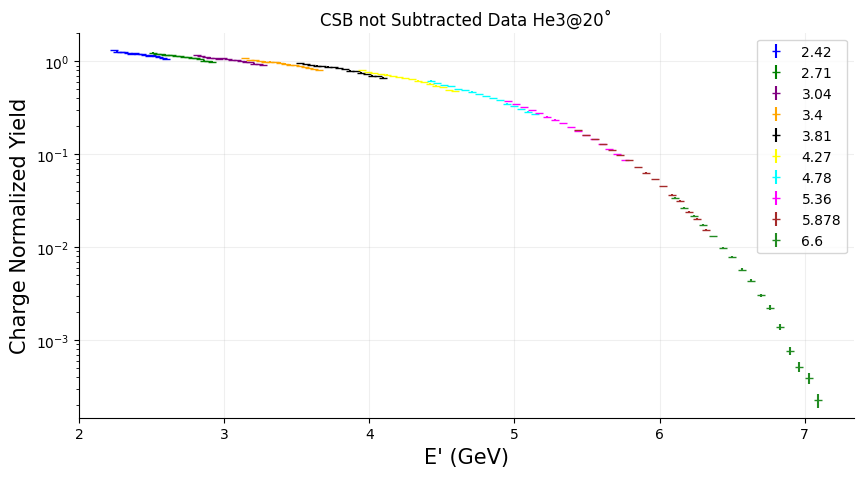

In [7]:
fig, ax = shaxes(title = f'CSB not Subtracted Data {ntg}@{idang}˚', xlabel = "E' (GeV)", ylabel = 'Charge Normalized Yield', yscale = 'log')
[ax.errorbar(ep_centers[mom], subtracted_csb_contents_ntg[mom], yerr = subtracted_csb_errors_ntg[mom], fmt = '_', color = colors[mom], label = f'{mom}') for mom in dmom]
ax.legend()
# fig.savefig(f'{folder}/comp{start_time}.png', dpi = 300)

<h1 align = 'center'> TARGET SPECIFIC DATA YIELD CORRECTION</h1>

In [8]:
corrections = {
    'Ca48': ("Correcting for Ca40 contamination in Ca48 target", 0.113, 'Ca40'),
    'B10': ("Correcting for C12 contamination in B10 target", 0.231, 'C12'),
    'B11': ("Correcting for C12 contamination in B11 target", 0.236, 'C12')
}

if ntg in corrections:
    msg, C, cont_tg = corrections[ntg]
    print(msg)
elif ntg in ['He3', 'LD2', 'He4']:
    print("Performing Aluminum cell wall subtraction")
    # C = 0.2165
    C = 0
    cont_tg = ald
else:
    print("No contamination correction needed")
    C = 0

if C:
    subtracted_csb_contents_cont, subtracted_csb_errors_cont = arrays_nucl(tg = cont_tg)
    for momentum in dmom:
        subtracted_csb_contents_ntg[momentum] = subtracted_csb_contents_ntg[momentum] - (C * subtracted_csb_contents_cont[momentum]) # Perform Contamination Subtraction
        subtracted_csb_errors_ntg[momentum] = np.sqrt((subtracted_csb_errors_ntg[momentum])**2 + (C * subtracted_csb_errors_cont[momentum])**2) # Add the errors in quadrature
        
    fig, ax = shaxes(xlabel = "E\' (GeV)", ylabel = 'Charge Normalized Yield', title = 'Contamination subtracted Data', yscale = 'log')
    [ax.errorbar(ep_centers[momentum], subtracted_csb_contents_ntg[momentum], yerr = subtracted_csb_errors_ntg[momentum], fmt = '_', color = colors[momentum], label = f'{momentum}') for momentum in dmom]
    # fig.savefig(f'{folder}/contamination_subtraction_yield_{ntg}_{time.time():.0f}.png', dpi = 300)

Performing Aluminum cell wall subtraction


<h1 align="center">SIMULATION WORK FOR NTG</h1>


In [ ]:
mc_yield, mc_errors, shesh = mc_array(tg = ntg)
# fig, ax = shaxes(xlabel = "E'", ylabel = 'MC Yield', title = f'{ntg}@{idang}˚')
# [ax.errorbar(ep_centers[momentum], mc_yield[momentum], yerr = mc_errors[momentum], fmt = '_', color = 'black') for momentum in dmom]
# fig.savefig(f'{folder}/epmc_{ntg}_{dang}_{start_time:.0f}.png', dpi = 300)

In [10]:
V6 = shesh['V'][6]
V8 = shesh['V'][8]
V13 = shesh['V'][13]
points_ntg = shesh['pts']

<h1 align="center">DATA/SIMULATION YIELD RATIO FOR NTG</h1>


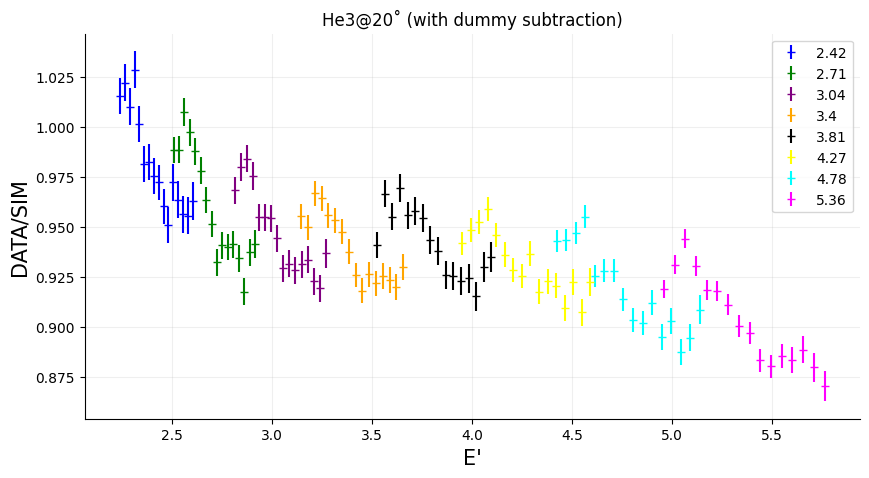

In [11]:
ratio_yield_ntg = {k: subtracted_csb_contents_ntg[k] / mc_yield[k] for k in mc_yield}
ratio_errors_ntg = {momentum: ratio_yield_ntg[momentum] * np.sqrt((subtracted_csb_errors_ntg[momentum] / subtracted_csb_contents_ntg[momentum])**2 + (mc_errors[momentum] / mc_yield[momentum])**2) for momentum in dmom}
fig, ax = shaxes(xlabel = "E'", ylabel = 'DATA/SIM', title = f'{ntg}@{idang}˚ (with dummy subtraction)')
[ax.errorbar(ep_centers[mom], ratio_yield_ntg[mom], yerr = ratio_errors_ntg[mom], fmt = '_', color = colors[mom], label = f'{mom}') for mom in dmom[:-2]]
ax.legend()

<h1 align="center">BORN CROSS SECTION CALCULATION FOR NTG</h1>


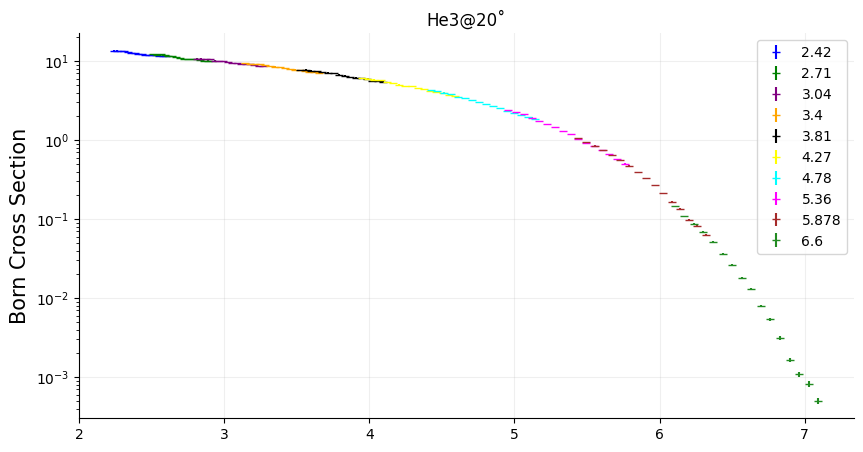

In [ ]:
# # Interpolate to get model Born cross-section. points_to_interpolate are the ACTUAL [E', theta] for our simulation. V6 - Born cross section
# born_xsec_array_ntg = {mom: griddata(points_ntg, V6, points_to_interpolate[mom], method = 'linear') for mom in dmom} # points is just the whole stack of 2D array of [E', theta] from the table
# # Get the QE piece
# qe_ntg = {mom: griddata(points_ntg, V8, points_to_interpolate[mom], method = 'linear') for mom in dmom}
# # Interpolate 3rd time to get Coulomb correction factor
# ccf_ntg = {mom: griddata(points_ntg, V13, points_to_interpolate[mom], method = 'linear') for mom in dmom}
# # Calculate the data Born cross-section and apply Coloumb corrections
# born_ntg = {mom: ratio_yield_ntg[mom] * born_xsec_array_ntg[mom] * ccf_ntg[mom] for mom in dmom}
# born_errors_ntg = {mom: born_ntg[mom] * ratio_errors_ntg[mom] for mom in dmom}

born_ntg, born_errors_ntg = get_xsec(ratio_yield = ratio_yield_ntg, ratio_errors = ratio_errors_ntg, columns = shesh)
fig, ax = shaxes(ylabel = 'Born Cross Section', title = f'{ntg}@{idang}˚', yscale = 'log')
[ax.errorbar(ep_centers[mom], born_ntg[mom], yerr = born_errors_ntg[mom], fmt = '_', color = colors[mom], label = f'{mom}') for mom in dmom]
ax.legend()
# fig.savefig(f'{folder}/xsec_{ntg}_{dang}_{start_time:.0f}.png', dpi = 300)

<h1 align="center">DATA WORK FOR DUMMY TARGET</h1>


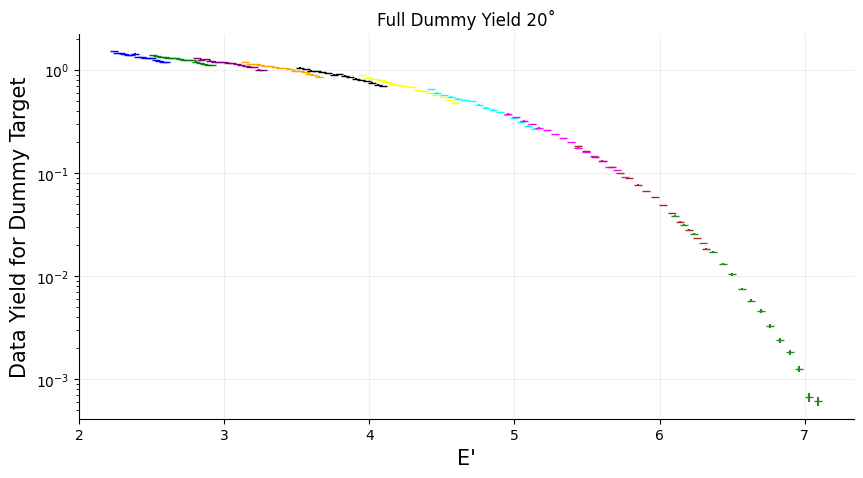

In [13]:
Eu = 0.19535 # Ratio of upstream dummy to target cell thickness
Ed = 0.23924 # Ratio of downstream dummy to target cell thickness

dummy_yield, dummy_errors = arrays_nucl(tg = ald)

fig, ax = shaxes(xlabel = "E'", ylabel = 'Data Yield for Dummy Target', title = f'Full {ald} Yield {idang}˚', yscale = 'log')
[ax.errorbar(ep_centers[mom], dummy_yield[mom], yerr = dummy_errors[mom], fmt = '_', color = colors[mom]) for mom in dmom];

<h1 align="center">DATA WORK FOR DTG</h1>

In [14]:
bin_contents_dtg, bin_errors_dtg = arrays_nucl(tg = dtg)

[<ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>]

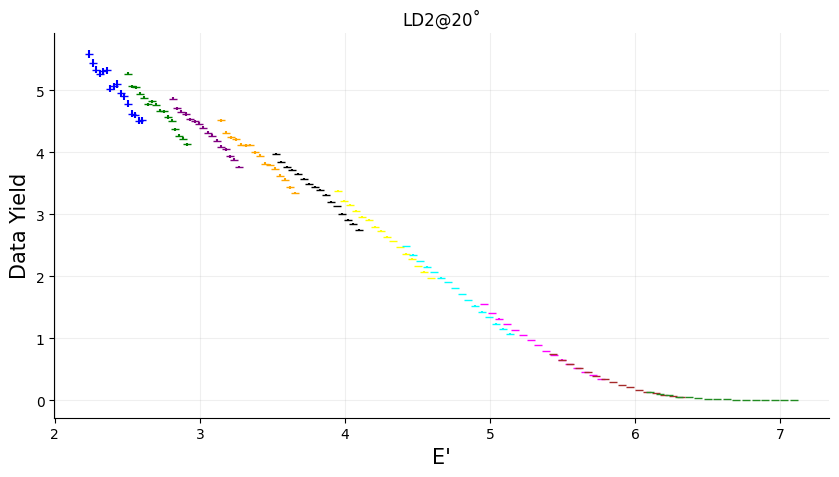

In [ ]:
fig, ax = shaxes(xlabel = "E'", title = f'{dtg}@{idang}˚', ylabel = 'Data Yield')
[ax.errorbar(ep_centers[mom], bin_contents_dtg[mom], yerr = bin_errors_dtg[mom], fmt = '_', color = colors[mom]) for mom in dmom];

<h2 style="text-align: center; color: silver">Subtracting CSB from full cryo target yield and dummy</h2>

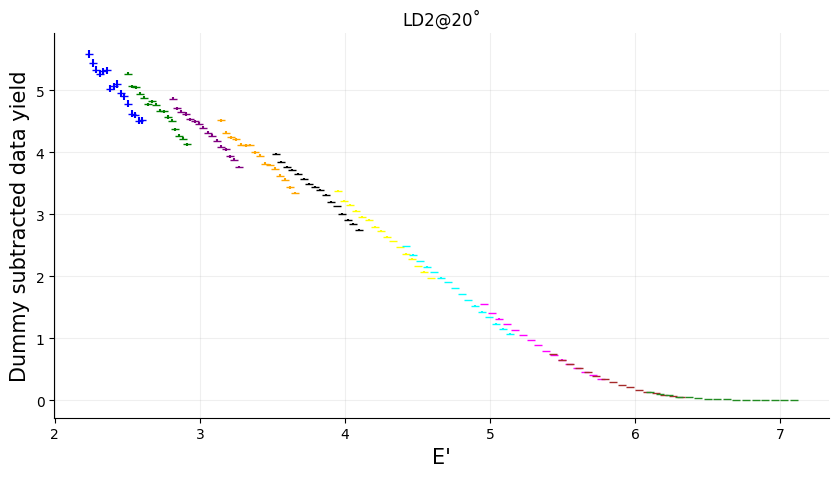

In [16]:
dtg_yield = {mom: bin_contents_dtg[mom] - (E * dummy_yield[mom]) for mom in dmom}
dtg_error = {mom: np.sqrt((bin_errors_dtg[mom])**2 + (E * dummy_errors[mom])**2) for mom in dmom}

fig, ax = shaxes(xlabel = "E'", title = f'{dtg}@{idang}˚', ylabel = 'Dummy subtracted data yield')
[ax.errorbar(ep_centers[mom], bin_contents_dtg[mom], yerr = bin_errors_dtg[mom], fmt = '_', color = colors[mom]) for mom in dmom];

<h1 align="center">SIMULATION WORK FOR DTG</h1>


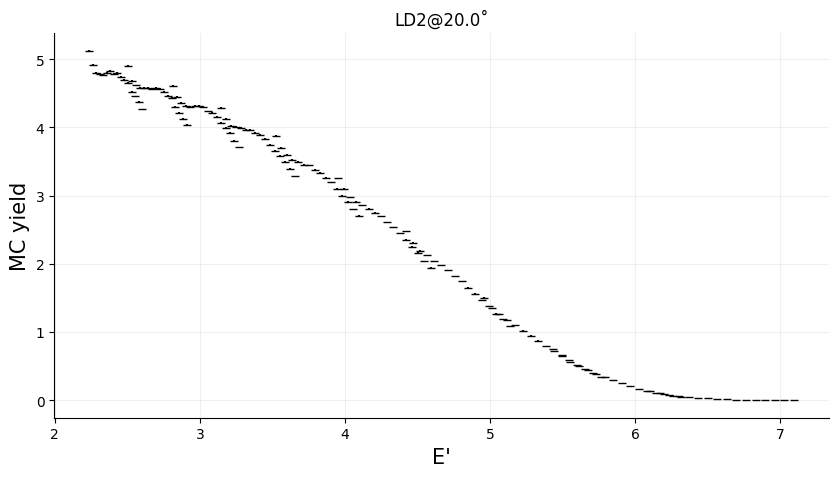

In [ ]:
mcyield_dtg, mcerrors_dtg, eedtg = mc_array(tg = dtg)
# fig, ax = shaxes(xlabel = "E'", ylabel = 'MC yield', title = f'{dtg}@{dang}˚')
# [ax.errorbar(ep_centers[mom], mcyield_dtg[mom], yerr = mcerrors_dtg[mom], fmt = '_', color = 'black') for mom in dmom];
# fig.savefig(f'{folder}/eprime_{dtg}_{dang}_{start_time:.0f}.png', dpi = 300)

<h1 align="center">DATA/SIMULATION YIELD RATIO FOR DTG</h1>

[<ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>]

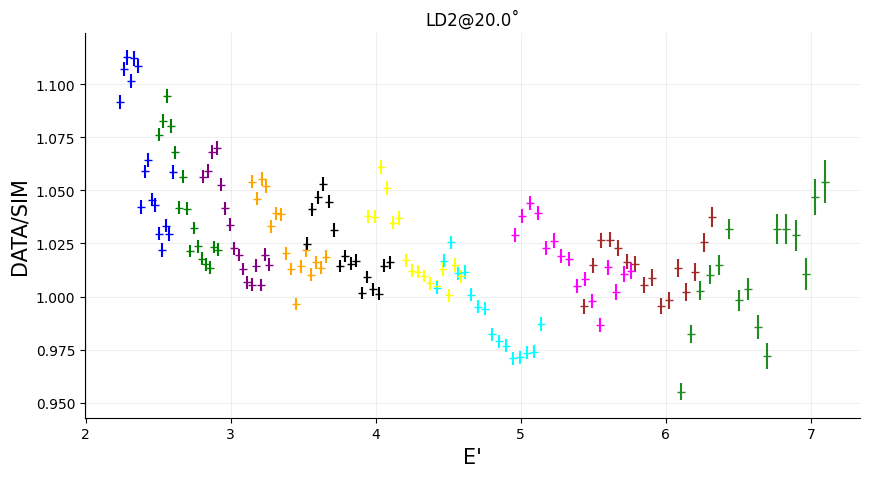

In [18]:
yield_ratio_dtg = {mom: bin_contents_dtg[mom] / mcyield_dtg[mom] for mom in dmom}
ratio_errors_dtg = {mom: yield_ratio_dtg[mom] * np.sqrt((bin_errors_dtg[mom] / bin_contents_dtg[mom])**2 + (mcerrors_dtg[mom] / mcyield_dtg[mom]))**2 for mom in dmom}

fig, ax = shaxes(xlabel = "E'", ylabel = 'DATA/SIM', title = f'{dtg}@{dang}˚')
[ax.errorbar(ep_centers[mom], yield_ratio_dtg[mom], yerr = ratio_errors_dtg[mom], fmt = '_', color = colors[mom]) for mom in dmom]
# fig.savefig(f'{folder}/ratio_eprime_{dtg}_{idang}{start_time:.0f}.png', dpi = 300)

<h1 align="center">BORN CROSS SECTION CALCULATION FOR DTG</h1>

[<ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>]

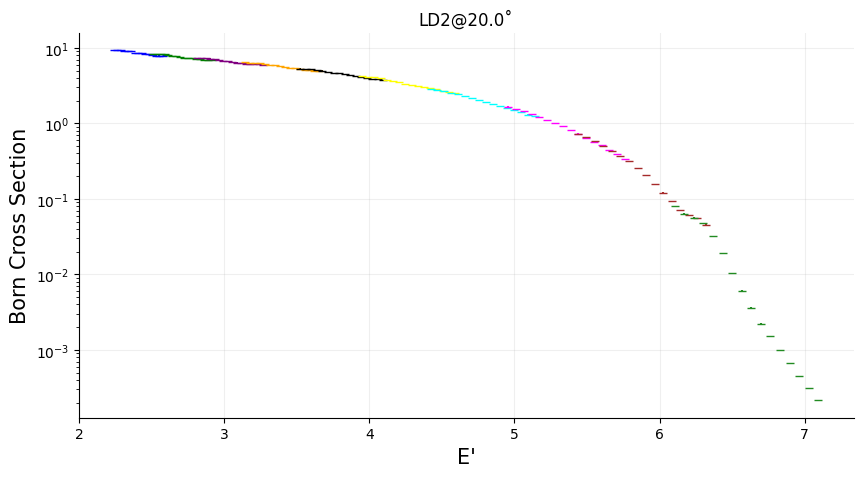

In [19]:
born_dtg, born_errors_dtg = get_xsec(ratio_yield = yield_ratio_dtg, ratio_errors = ratio_errors_dtg, columns = eedtg)

fig, ax = shaxes(xlabel = "E'", ylabel = 'Born Cross Section', title = f'{dtg}@{dang}˚', yscale = 'log')
[ax.errorbar(ep_centers[mom], born_dtg[mom], yerr = born_errors_dtg[mom], fmt = '_', color = colors[mom]) for mom in dmom]
# fig.savefig(f'{folder}/xsec_{dtg}_{dang}_{start_time:.0f}.png', dpi = 300)

<h1 align="center">TAKING CROSS-SECTION RATIOS</h1>

Per-nucleon scaling factor: 1.5
slope 0.0015851206214346056


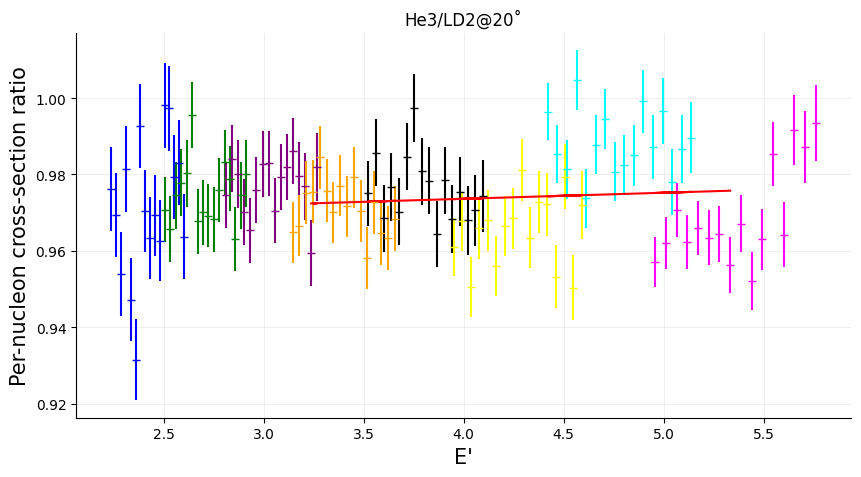

In [ ]:
born_ratio = {mom: born_ntg[mom] / born_dtg[mom] for mom in dmom}
born_ratio_errors = {mom: born_ratio[mom] * np.sqrt(born_errors_ntg[mom] / born_ntg[mom])**2 + (born_errors_dtg[mom] / born_dtg[mom]) for mom in dmom}
# fig, ax = shaxes(xlabel = "E'", ylabel = 'Cross-section ratio', title = f'{ntg}/{dtg}@{idang}˚')
# [ax.errorbar(ep_centers[mom], born_ratio[mom], yerr = born_ratio_errors[mom], fmt = '_', color = colors[mom]) for mom in dmom[:-2]]
# fig.savefig(f'{folder}/ratio_{dtg}_{dang}_{start_time:.0f}.png', dpi = 300)

nA, nZ = target_info[ntg][1], target_info[ntg][0]
dA = target_info[dtg][1]
sf = nA / dA
print("Per-nucleon scaling factor:", sf)

csr = {mom: born_ratio[mom] / sf for mom in dmom}
csr_array = np.concatenate([csr[mom] for mom in dmom])
csr_errors = {mom: born_ratio_errors[mom] / sf for mom in dmom}
bin_centers = np.concatenate([ep_centers[mom] for mom in dmom])
fig, ax = shaxes(xlabel = "E'", ylabel = 'Per-nucleon cross-section ratio', title = f'{ntg}/{dtg}@{idang}˚')
[ax.errorbar(ep_centers[mom], csr[mom], yerr = csr_errors[mom], fmt = '_', color = colors[mom]) for mom in dmom[:-2]]
# fig.savefig(f'{folder}/csr_{ntg}_{dtg}_{dang}_{start_time:.0f}.png', dpi = 300)

<h1 align="center">Converting to Bjorken-x</h1>

absolute value of slope 0.03889569669767412
EMC Ratio at x = 0.3: 0.9697647461229554


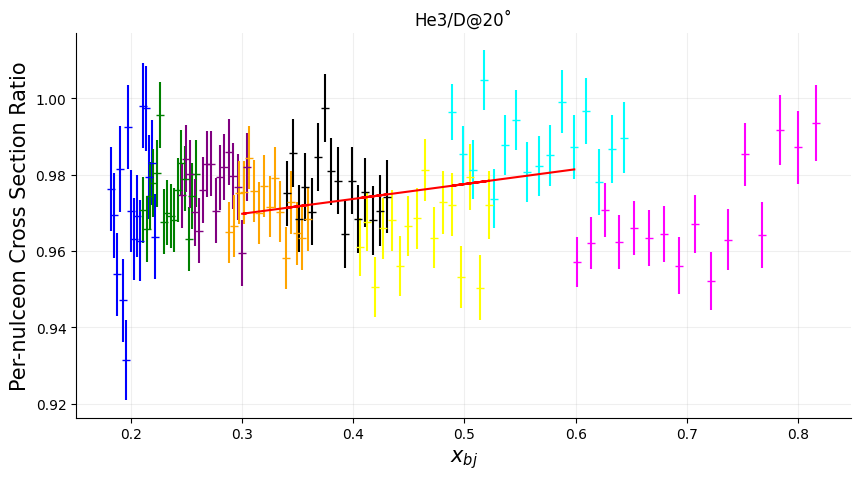

In [ ]:
bj_centers = {mom: (4 * Ei * ep_centers[mom] * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - ep_centers[mom])) for mom in dmom}

fig, ax = shaxes(xlabel = r'$x_{bj}$', ylabel = 'Per-nulceon Cross Section Ratio', title = f'{ntg}/D@{idang}˚')
[ax.errorbar(bj_centers[mom], csr[mom], yerr = csr_errors[mom], fmt = '_', color= colors[mom]) for mom in dmom[:-2]]

bjx_bin_centers = np.concatenate([bj_centers[mom] for mom in dmom])
mask = (bjx_bin_centers >= fit_lo) & (bjx_bin_centers <= fit_high) & ~np.isnan(csr_array)
filtered_bin_centers, filtered_csr = bjx_bin_centers[mask], csr_array[mask]

slope, intercept, r_value, p_value, std_err = stats.linregress(filtered_bin_centers, filtered_csr)
print("absolute value of slope", abs(slope))
print("EMC Ratio at x = 0.3:", slope * np.min(filtered_bin_centers) + intercept)
ax.plot(filtered_bin_centers, slope * filtered_bin_centers + intercept, 'r')
# fig.savefig(f'{folder}/emc_{ntg}_{dtg}_{dang}_{start_time:.0f}.png', dpi = 300)

<h1 align="center">Calculating isoscalar correction factor</h1>

\begin{equation}
    \left( \frac{\sigma_A}{\sigma_D} \right)_{\text{ISO}} = \frac{A}{2} \left( \frac{1 + \frac{\sigma_n}{\sigma_p}}{Z + N \frac{\sigma_n}{\sigma_p}} \right) \frac{\sigma_A}{\sigma_D},
\end{equation}

\begin{equation}
    \text{isoscalar factor} = \frac{A}{2} \left( \frac{1 + \frac{\sigma_n}{\sigma_p}}{Z + N \frac{\sigma_n}{\sigma_p}} \right)
\end{equation}

\begin{equation}
    \text{isoscalar all} = \frac{\sigma_n}{\sigma_p}
\end{equation}

Average of q2_all 5.379052377211707
Average of Bjorken x 0.5149349474719035


[[<matplotlib.lines.Line2D at 0x314ed6140>],

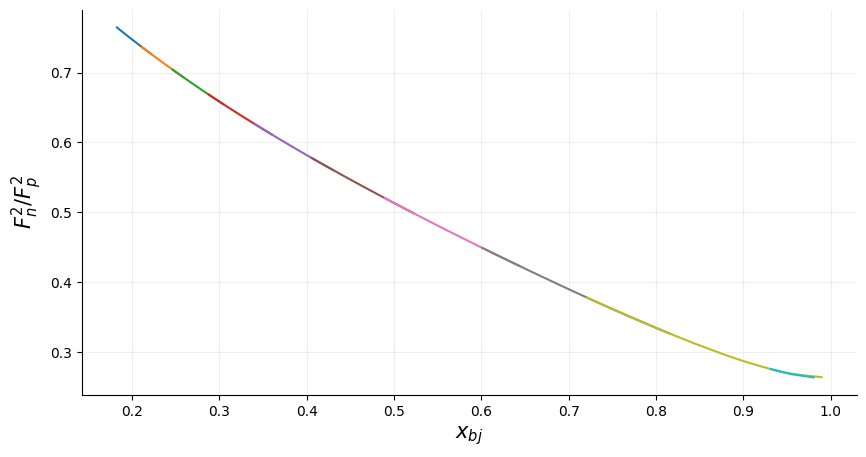

In [ ]:
q2_all = 4 * Ei * bin_centers * (np.sin(dang * np.pi / 180 / 2))**2
q2 = {mom: 4 * Ei * ep_centers[mom] * (np.sin(dang * np.pi / 180 / 2))**2 for mom in dmom}
# print(f"The minimum and maximum Q^2 values are {np.min(q2_all):.2f} and {np.max(q2_all):.2f}")

isoscalar = {mom: jra_np(bj_centers[mom], q2[mom]) for mom in dmom}

fig, ax = shaxes(xlabel = r'$x_{bj}$', ylabel = r'$F^2_n/F^2_p$')
# plt.plot(bjx_bin_centers[isoscalar_all != 1], isoscalar2[isoscalar_all != 1], '_', color = 'blue');
[ax.plot(bj_centers[mom][isoscalar[mom]!=1], isoscalar[mom][isoscalar[mom]!=1]) for mom in dmom];

nN = nA - nZ
print(f"nN {nN} nZ {nZ} nA {nA}")

isoscalar_factor = {mom: (nA / 2 * (1 + isoscalar[mom])) / (nZ + (nN * isoscalar[mom])) for mom in dmom}

# Apply isoscalar correction to cross-section ratios
iso_csr = {mom: csr[mom] * isoscalar_factor[mom] for mom in dmom}
# fig, ax = shaxes(xlabel = r'$x_{bj}$', ylabel = 'Isoscalar Factor')
# [ax.plot(bj_centers[mom], isoscalar_factor[mom], color = colors[mom]) for mom in dmom]

# Calculating and Plotting the final Cross-Section Ratios

Value of isoscalar corrected slope -0.12145044043080927
EMC Ratio at x = 0.3: 0.9071177005561728


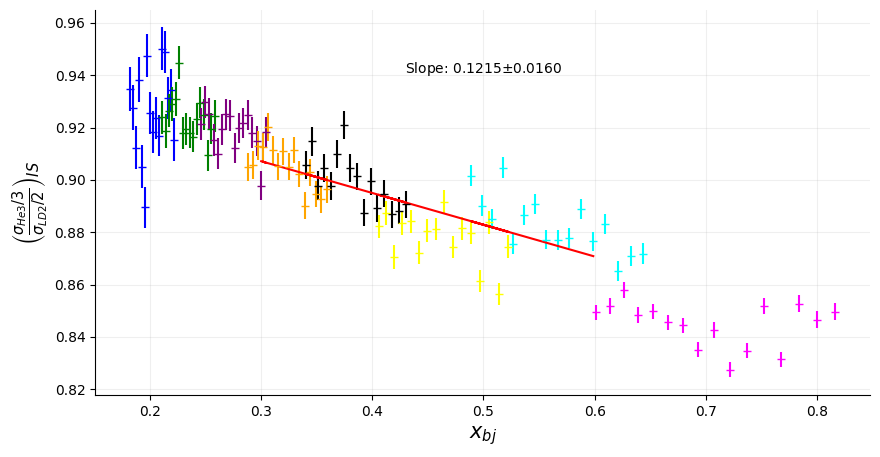

In [25]:
fig, ax = shaxes(xlabel = r'$x_{bj}$')
isocsr_errors = {mom: csr_errors[mom] * isoscalar[mom] for mom in dmom} 
[ax.errorbar(bj_centers[mom], iso_csr[mom], yerr = isocsr_errors[mom], fmt = '_', color = colors[mom], label = f'{mom}') for mom in dmom[:-2]]
if nZ == nN:
    ax.set_ylabel(f'$\\frac{{σ_{{{ntg}}}/{nA}}}{{σ_{{{dtg}}}/{dA}}}$')
else:
    ax.set_ylabel(f'$\\left(\\frac{{σ_{{{ntg}}}/{nA}}}{{σ_{{{dtg}}}/{dA}}}\\right)_{{IS}}$')

iso_csr_array = np.concatenate([iso_csr[mom] for mom in dmom])
bin_errors = np.concatenate([isoscalar[mom] * csr_errors[mom] for mom in dmom])
filtered_iso_csr = iso_csr_array[mask]

iso_slope, iso_intercept, iso_r_value, iso_p_value, iso_std_err = stats.linregress(filtered_bin_centers, filtered_iso_csr)
print("Value of isoscalar corrected slope", iso_slope)
norm_3 = iso_slope * np.min(filtered_bin_centers) + iso_intercept
# print("Error on slope", iso_std_err)
print("EMC Ratio at x = 0.3:", norm_3)
ax.plot(filtered_bin_centers, iso_slope * filtered_bin_centers + iso_intercept, 'r')
ax.text(0.4, 0.79, f'Slope: {abs(iso_slope):.4f}$\pm${iso_std_err:.4f} \n', transform = ax.transAxes);
# fig.savefig(f'{folder}/isoscalarcorrected_emc_{ntg}_{idang}_{start_time:.0f}.png', dpi = 300)

# Write the final cross-section ratios to a file

In [ ]:
csr_errors_array       = np.concatenate([csr_errors[mom] for mom in dmom])
yield_ratio_dtg_array  = np.concatenate([yield_ratio_dtg[mom] for mom in dmom])
ratio_errors_dtg_array = np.concatenate([ratio_errors_dtg[mom] for mom in dmom])
ratio_errors_ntg_array = np.concatenate([ratio_errors_ntg[mom] for mom in dmom])
ratio_yield_ntg_array  = np.concatenate([ratio_yield_ntg[mom] for mom in dmom])
np.savez(f'{folder}/{ntg}_{idang}.npz', bjx = bjx_bin_centers, csr = csr_array,  csr_errors = csr_errors_array, yield_ratio_dtg = yield_ratio_dtg_array,
                                    ratio_errors_dtg = ratio_errors_dtg_array, ratio_errors_ntg = ratio_errors_ntg_array, ratio_yield_ntg = ratio_yield_ntg_array)

In [27]:
minutes = (time.time() - start_time) / 60
print(f"Time taken: {minutes:.2f} minutes")
# baja()

Time taken: 9.10 minutes
